In [2]:
import pandas as pd
import numpy as np
import warnings

warnings.filterwarnings("ignore")

In [14]:
bikes = pd.read_csv('../Datasets/bikes.csv')

adult_data = pd.read_csv('../Datasets/adult_train.csv', index_col=0)
adult_data.replace(to_replace=' ?', value=np.nan, inplace=True)
adult_data.dropna(inplace=True)
adult_data.reset_index(drop=True).head()

,age,work-class,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,target
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


#### Find colinear features

In [3]:
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.spearmanr.html
from scipy.stats import spearmanr
import matplotlib.pyplot as plt
from matplotlib import colors

def vis_dataframe(df):

    def background_gradient(s, m, M, cmap='PuBu', low=0, high=0):
        rng = M - m
        norm = colors.Normalize(m - (rng * low),
                                M + (rng * high))
        normed = norm(s.values)
        c = [colors.rgb2hex(x) for x in plt.cm.get_cmap(cmap)(normed)]
        return ['background-color: %s' % color for color in c]

    df_color = pd.DataFrame(df, index=df.columns)
    df_color = df_color.transpose()
    return df_color.style.apply(background_gradient,
                          cmap='PuBu',
                          m=df_color.min().min(),
                          M=df_color.max().max(),
                          low=0,
                          high=0.2)

def calc_correlation(data):
    corr = np.round(spearmanr(data).correlation, 4)
    df_corr = pd.DataFrame(data=corr, index=data.columns, columns=data.columns)
    return df_corr

def show_corr_features(df, cut_off=0.75):
    features = df.columns
    corr_dic = {}
    for f in features:
        indices = df.loc[(df[f] >= cut_off) & (df[f] != 1)].index
        corr = df.loc[(df[f] >= cut_off) & (df[f] != 1)][f]
        if len(indices) > 0:
            for i in range(len(corr)):
                if not (indices[i], f) in corr_dic.keys():
                    corr_dic[(f, indices[i])] = corr[i]
    
    if len(corr_dic) == 0:
        print('There is no correlated features in this dataset')
    else:
        print('The following dataframe shows the correlated features in this dataset')
        corr_df = pd.DataFrame(corr_dic, index=['spearmanr_corr']).transpose()
        return corr_df.sort_values('spearmanr_corr', ascending=False)
    

In [4]:
df_corr = calc_correlation(bikes)
vis_dataframe(df_corr)

/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:248: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  "values. nan values will be ignored.", RuntimeWarning)


,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
instant,1,1,0.4043,0.866,0.4892,-0.0048,0.0147,0.0013,-0.0034,-0.0075,0.1279,0.1264,0.0075,-0.0732,0.1594,0.2561,0.2437
dteday,1,1,0.4043,0.866,0.4892,-0.0061,0.0147,0.0013,-0.0034,-0.0074,0.1278,0.1263,0.0079,-0.0734,0.1588,0.2554,0.243
season,0.4043,0.4043,1,-0.0107,0.8308,-0.0061,-0.0095,-0.0023,0.0137,-0.0133,0.3058,0.3058,0.1475,-0.1369,0.1837,0.1824,0.1852
yr,0.866,0.866,-0.0107,1,-0.0104,-0.0039,0.0067,-0.0045,-0.0022,-0.0132,0.0364,0.0353,-0.0831,-0.0107,0.1147,0.221,0.2075
mnth,0.4892,0.4892,0.8308,-0.0104,1,-0.0057,0.0187,0.0103,-0.0037,0.0086,0.1914,0.1908,0.1597,-0.1299,0.1181,0.1271,0.1259
hr,-0.0048,-0.0061,-0.0061,-0.0039,-0.0057,1,0.0005,-0.0035,0.0023,-0.0303,0.134,0.133,-0.2785,0.1404,0.4767,0.5106,0.5109
holiday,0.0147,0.0147,-0.0095,0.0067,0.0187,0.0005,1,-0.1019,-0.2525,-0.0129,-0.0281,-0.0315,-0.0123,0.0041,0.0159,-0.0435,-0.0295
weekday,0.0013,0.0013,-0.0023,-0.0045,0.0103,-0.0035,-0.1019,1,0.035,0.0033,-0.0057,-0.013,-0.0366,0.0099,0.0127,0.0347,0.0303
workingday,-0.0034,-0.0034,0.0137,-0.0022,-0.0037,0.0023,-0.2525,0.035,1,0.0439,0.055,0.0541,0.0173,-0.0107,-0.1767,0.0831,0.021
weathersit,-0.0075,-0.0074,-0.0133,-0.0132,0.0086,-0.0303,-0.0129,0.0033,0.0439,1,-0.1045,-0.1111,0.4094,0.0083,-0.1603,-0.1121,-0.1263


In [33]:
show_corr_features(df_corr)

The following dataframe shows the correlated features in this dataset


,,spearmanr_corr
temp,atemp,0.9896
registered,cnt,0.9894
instant,yr,0.8660
dteday,yr,0.8660
casual,cnt,0.8505
season,mnth,0.8308
casual,registered,0.7811


#### Drop column importance

In [6]:
from sklearn.ensemble import RandomForestClassifier

def dropcol_importance(model, X_train, y_train):
    
    X = pd.get_dummies(X_train,drop_first=True)
    clf = model.fit(X, y_train)
    base_score = clf.score(X, y_train)
    imp = []
    for col in X_train.columns:
        X_ = pd.get_dummies(X_train.drop(col, axis=1), drop_first=True)
        clf_ = model
        score_ = clf_.fit(X_, y_train).score(X_, y_train)
        imp.append(np.round(base_score - score_, 4))
        
    df_imp = pd.DataFrame({'Features': X_train.columns, 'Importance': imp})
    return df_imp.sort_values('Importance', ascending=False)

In [7]:
model = RandomForestClassifier(random_state=1, n_estimators=10)
# pick only numeric features
# numeric_features = [i for i in adult_data.columns if adult_data[i].dtype in [np.int64]]
# X_train = adult_data[numeric_features]
X_train = adult_data.drop('target', axis=1)
y_train = adult_data['target']
dropcol_importance(model, X_train, y_train)

,Features,Importance
2,fnlwgt,0.0232
0,age,0.0028
10,capital-gain,0.0025
12,hours-per-week,0.0024
6,occupation,0.0014
11,capital-loss,0.0008
8,race,0.0005
9,sex,0.0004
1,work-class,0.0001
13,native-country,-0.0000


#### Permutation Importance

In [8]:
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype

In [7]:
def permutation_importance(model, X_train, y_train):
    
    X = pd.get_dummies(X_train, drop_first=True)
    clf = model.fit(X, y_train)
    base_score = clf.score(X, y_train)
    imp = []
    for col in X_train.columns:
        X_ = X_train.copy()
        X_[col] = np.random.permutation(X_[col])
        X_ = pd.get_dummies(X_, drop_first=True)
        score_ = clf.score(X_, y_train)
        imp.append(np.round(base_score - score_, 4))
        
    df_imp = pd.DataFrame({'Features': X_train.columns, 'Importance': imp})
    return df_imp.sort_values('Importance', ascending=False)

In [10]:
# from sklearn.ensemble import RandomForestClassifier
# df_label = DataEncoding(adult_data)
# df_label = df_label.label_encoding()
# model = RandomForestClassifier(random_state=1, n_estimators=10)
# permutation_importance(model, df_label.drop('target', axis=1), df_label['target'])

In [11]:
model = RandomForestClassifier(random_state=1, n_estimators=10)
permutation_importance(model, adult_data.drop('target', axis=1), adult_data['target'])

,Features,Importance
6,occupation,0.1149
0,age,0.1050
5,marital-status,0.1031
2,fnlwgt,0.0814
3,education,0.0743
12,hours-per-week,0.0695
4,education-num,0.0633
1,work-class,0.0574
7,relationship,0.0559
10,capital-gain,0.0505


In [11]:
model = RandomForestClassifier(random_state=1, n_estimators=10)
# pick only numeric features
numeric_features = [i for i in adult_data.columns if is_numeric_dtype(adult_data[i])]
X_train = adult_data[numeric_features]
y_train = adult_data['target']
permutation_importance(model, X_train, y_train)

,Features,Importance
0,age,0.1806
2,education-num,0.1688
1,fnlwgt,0.1545
5,hours-per-week,0.1322
3,capital-gain,0.0716
4,capital-loss,0.0313


#### Permutation Importance using eli5

In [12]:
import eli5
from sklearn.model_selection import train_test_split
from eli5.sklearn import PermutationImportance

numeric_features = [i for i in adult_data.columns if is_numeric_dtype(adult_data[i])]
X_train = adult_data[numeric_features]

y = adult_data['target']
# train_X, test_X, train_y, test_y = train_test_split(X_train, y, random_state=0)
# rf_model = RandomForestClassifier(random_state=0, n_estimators=10).fit(train_X, train_y.ravel())
# perm = PermutationImportance(rf_model, random_state=0).fit(test_X, test_y)
# eli5.show_weights(perm, feature_names=test_X.columns.tolist())

rf_model = RandomForestClassifier(random_state=0, n_estimators=10).fit(X_train, y)
perm = PermutationImportance(rf_model, random_state=0).fit(X_train, y)
eli5.show_weights(perm, feature_names=X_train.columns.tolist())

/anaconda3/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


Weight,Feature
0.1807 ± 0.0037,age
0.1697 ± 0.0042,education-num
0.1581 ± 0.0023,fnlwgt
0.1328 ± 0.0023,hours-per-week
0.0728 ± 0.0008,capital-gain
0.0315 ± 0.0011,capital-loss


#### Shapley value

In [3]:
from collections import defaultdict
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
class DataEncoding:

    def __init__(self, data):
        self.data = data
            
    def get_cat_features(self, data):
        cat_features = [c for c in data.columns if is_string_dtype(data[c])]
        return cat_features
    
    def get_num_features(self, data):
        num_features = [c for c in data.columns if is_numeric_dtype(data[c])]
        return num_features
    
    def label_encoding(self):
        d = defaultdict(LabelEncoder)
        cat_features = self.get_cat_features(self.data)
        df = self.data.copy()
        for name in cat_features:
            df[name] = df[[name]].apply(lambda x: d[name].fit_transform(x))
        return df
            
    def discretization(self, quantiles=10):
        num_features = self.get_num_features(self.data)
        df = self.data.copy()
        for name in num_features:
            df[name] = pd.qcut(df[name], quantiles , duplicates='drop').astype(str)
        return df
    
    def onehot_encoding(self):
        df = self.data.copy()
        return pd.get_dummies(df)
    
def standarizing(data):
    df = data.copy()
    num_features = [c for c in df.columns if is_numeric_dtype(df[c])]
    df[num_features] = preprocessing.scale(df[num_features])
    return df
        

In [7]:
from sklearn.ensemble import RandomForestClassifier

adult_data = pd.read_csv('../Datasets/adult_train.csv', index_col=0)
data = DataEncoding(adult_data)
df_adult = data.label_encoding()
X = df_adult.drop('target', axis=1)
y = df_adult['target'].astype(bool)

rf_model = RandomForestClassifier(random_state=1, n_estimators=10).fit(X, y)

In [60]:
import shap

shap.initjs()

explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X.iloc[:100])

In [35]:
shap.force_plot(explainer.expected_value[1], shap_values[1][20, :], X.iloc[20, :])

In [1]:
# shap_inter = np.array(explainer.shap_interaction_values(X.iloc[:10]))


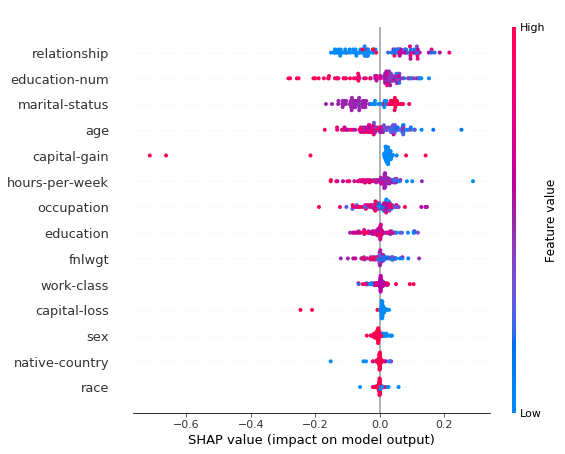

In [20]:
shap.summary_plot(shap_values[0], features=X.iloc[:100])

In [23]:
shap.force_plot(explainer.expected_value[1], shap_values[1], X.iloc[:100])

In [41]:
shap.force_plot(explainer.expected_value[1], shap_values[1], X.iloc[:100])

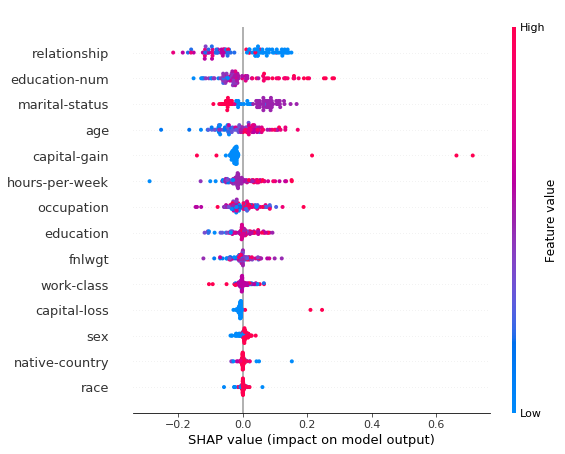

In [42]:
shap.summary_plot(shap_values[1], X.iloc[:100])

In [63]:
# for name in X.columns:
#     shap.dependence_plot(name, shap_values[1], X.iloc[:100], display_features=X.iloc[:100])

### Census income classification with LightGBM

In [14]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
params = {
    "max_bin": 512,
    "learning_rate": 0.05,
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": "binary_logloss",
    "num_leaves": 10,
    "verbose": -1,
    "min_data": 100,
    "boost_from_average": True
}

adult_data = pd.read_csv('../Datasets/adult_train.csv', index_col=0)
data = DataEncoding(adult_data)
df_adult = data.label_encoding()
X = df_adult.drop('target', axis=1)
y = df_adult['target'].astype(bool)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)
d_train = lgb.Dataset(X_train, label=y_train)
d_test = lgb.Dataset(X_test, label=y_test)

model = lgb.train(params, d_train, 10000, valid_sets=[d_test], early_stopping_rounds=50, verbose_eval=1000)
    

Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[748]	valid_0's binary_logloss: 0.278144


In [16]:
import shap
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

In [72]:
model.predict(X)[:11]

array([1.76816563e-04, 2.82073599e-01, 2.54315424e-02, 8.64048386e-02,
       3.67127395e-01, 7.89114487e-01, 6.66297378e-03, 3.89155445e-01,
       9.99855095e-01, 9.81557997e-01, 6.53375404e-01])

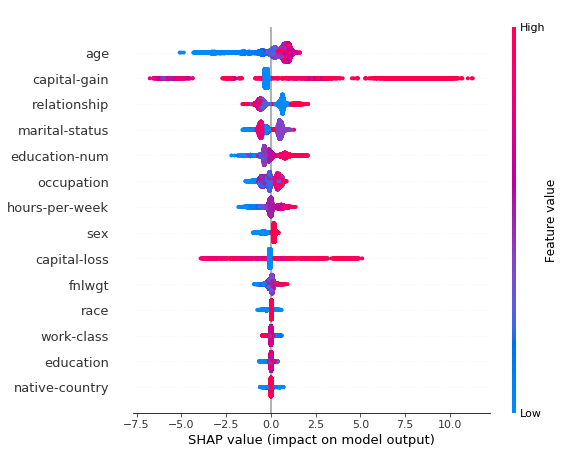

In [64]:
shap.summary_plot(shap_values, X)

In [62]:
# for name in X.columns:
#     shap.dependence_plot(name, shap_values, X, display_features=X)

In [ ]:
def label_encoding(data):
    d = defaultdict(LabelEncoder)
    for c in data.columns:
        if is_string_dtype(data[c]):
            data[c] = data[[c]].apply(lambda x: d[c.name].fit_transform(x))
            
    return data.head()